In [1]:
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Convolution2D, Dropout, MaxPool2D, Flatten
from keras.activations import relu, softmax
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,ModelCheckpoint
import tensorboard

from scipy import misc
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import time

Using TensorFlow backend.


In [2]:
train = False
save = train
load = !train

In [3]:
numberClasses = 3
batchSize = 256
targetSize = 64
dropOut = 0.5

model = Sequential()
model.add(Convolution2D(filters = 64, kernel_size= (3,3), input_shape= (targetSize,targetSize,3),activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Convolution2D(filters =64, kernel_size= (3,3),activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Convolution2D(filters =64, kernel_size= (3,3),activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Convolution2D(filters =64, kernel_size= (3,3),activation = 'relu', ))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dropout(dropOut))

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(dropOut))

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(dropOut))

model.add(Dense(units = numberClasses, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          36928     
__________

In [4]:
if train:
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    test_datagen = ImageDataGenerator(
            rescale=1./255)

    training_set = train_datagen.flow_from_directory(
        'dataset/training_set',
        target_size=(targetSize, targetSize),
        batch_size=batchSize,
        class_mode='categorical')

    test_set = test_datagen.flow_from_directory(
        'dataset/test_set',
        target_size=(targetSize, targetSize),
        batch_size=batchSize,
        class_mode='categorical')

    checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=False)
    tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,batch_size = batchSize, write_grads=True, write_images=True)

    model.fit_generator(
        training_set,
        max_queue_size=10,
        workers = 10,
        steps_per_epoch=8000/batchSize,
        epochs=20,
        validation_data=test_set,
        validation_steps=2000/batchSize,callbacks=[tensorboard] )

In [5]:
if save:
    model.save("./models/{}".format(time.time()))

### Result
32/31 [==============================] - 7s 213ms/step - loss: 0.0850 - acc: 0.9732 - val_loss: 0.0109 - val_acc: 1.0000

## Loading model and testin

In [6]:
if load:
    model = load_model("./models/modelThreeClass.h5")

## Test

In [7]:
def readImages(path,imgRows, imgCols,channels):
    newPath = path # [folder for folder in listdir(path) if not isfile(join(path,folder))]
    
    allImages = []

    images = [f for f in listdir(newPath) if (isfile(join(newPath, f)) and (f[-4:]==".jpg" or f[-4:]==".png"))]

    for img in images:
        tmpPath = join(newPath, img)
        if channels == 1:
            img = misc.imread(tmpPath,'F')
        else: 
            img = misc.imread(tmpPath)
        img = misc.imresize(img, (imgRows,imgCols))
        img = img.astype(np.float32)
        img /= 255.
        img = np.reshape(img, (imgRows, imgCols,channels))
        allImages.append(img)
    return np.array(allImages)

test = readImages("./dataset/test",64,64,3)

In [8]:
xTest = test

## Classifying

In [9]:
%%time
for i in range(10):
    data = model.predict_classes(xTest,batch_size = 1)

114/114 [==============================] - 0s     
CPU times: user 11.5 s, sys: 853 ms, total: 12.4 s
Wall time: 3.3 s


In [10]:
print(data)
print (len(data))

[2 0 0 0 0 0 2 2 2 0 2 2 0 0 2 2 2 0 2 2 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0
 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1
 0 0 1 1 0 0 0 1 1 0 1 2 2 0 2 2 2 2 0 0 0 0 0 2 2 2 0 2 0 0 0 2 2 2 2 0 0
 0 2 2]
114


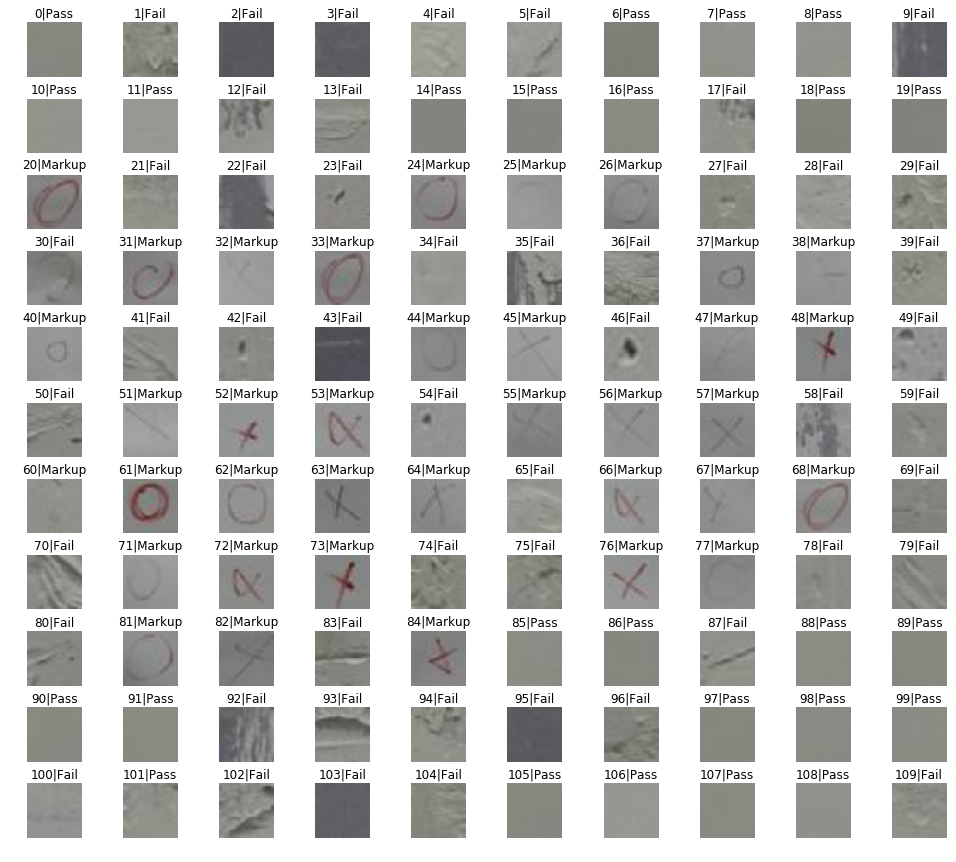

CPU times: user 7.65 s, sys: 196 ms, total: 7.85 s
Wall time: 7.88 s


In [12]:
%%time
size = 11
sizeV =10
labels = ["Fail","Markup","Pass"]
f, axarr = plt.subplots(size, sizeV, figsize=(15,15))
for i in range(size):
    for j in range (sizeV):
        index = i*sizeV+j
        axarr[i,j].imshow((test[index]))
        label = labels[data[index]]

        axarr[i,j].set_title(str(index)+ "|"+ label)
        axarr[i,j].axis('off')
    
plt.axis('off')
f.subplots_adjust(left=None, bottom=None, right=1, top=None,
                wspace=.2, hspace=.4)
plt.show()

In [13]:
images = [f for f in listdir("./dataset/test") if (isfile(join("./dataset/test", f)) and (f[-4:]==".jpg" or f[-4:]==".png"))]

labels = [int (name[0]) for name in images]
print (labels)

[2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2]


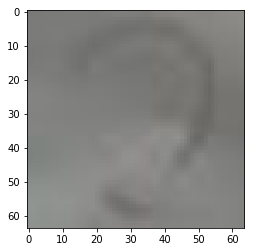

30> Real: 1 | Output: 0


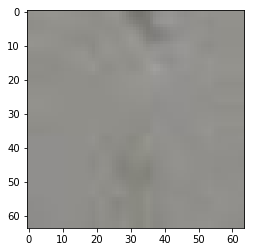

60> Real: 0 | Output: 1


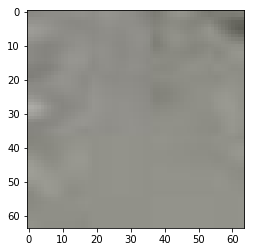

101> Real: 0 | Output: 2


In [14]:
counter = 0
for i in range (len (labels)):
    if labels[i] != data[i]:
        counter += 1
        plt.imshow((test[i]))
        plt.show()
        print ("{}> Real: {} | Output: {}".format (i,labels[i],data[i]))

In [15]:
print (counter, 1-  counter/len(labels))       

3 0.9736842105263158


In [42]:
#model.save("./models/{}".format("3Class_97.5h"))